In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [3]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Product_Name", 
         "Delivery_Year", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [4]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy="mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns=cols)

    return (data)

In [16]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [17]:
for d in dates:
        data[d] = pd.to_datetime(data[d])

In [19]:
data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days == 0

In [20]:
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]

In [45]:
data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days

In [48]:
data["Ble"] = data.Concrete_Offer < 60

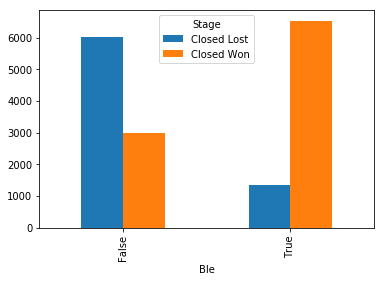

In [51]:
pd.crosstab(data.Ble, data.Stage).plot(kind='bar')

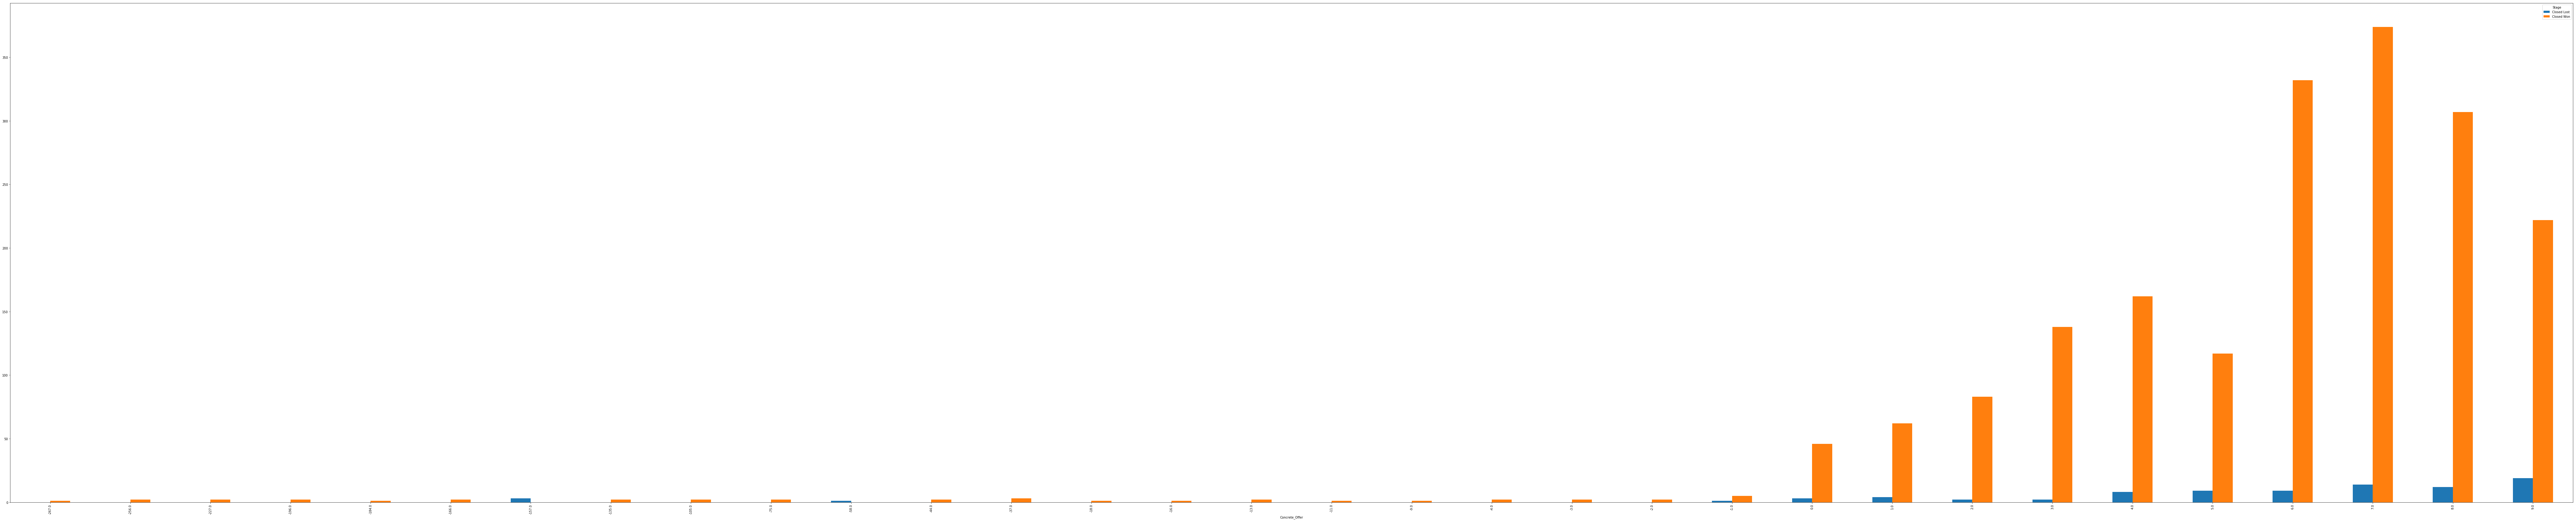

In [44]:
pd.crosstab(data[data.Concrete_Offer < 10].Concrete_Offer, data.Stage).plot(kind='bar', figsize=(150, 30))

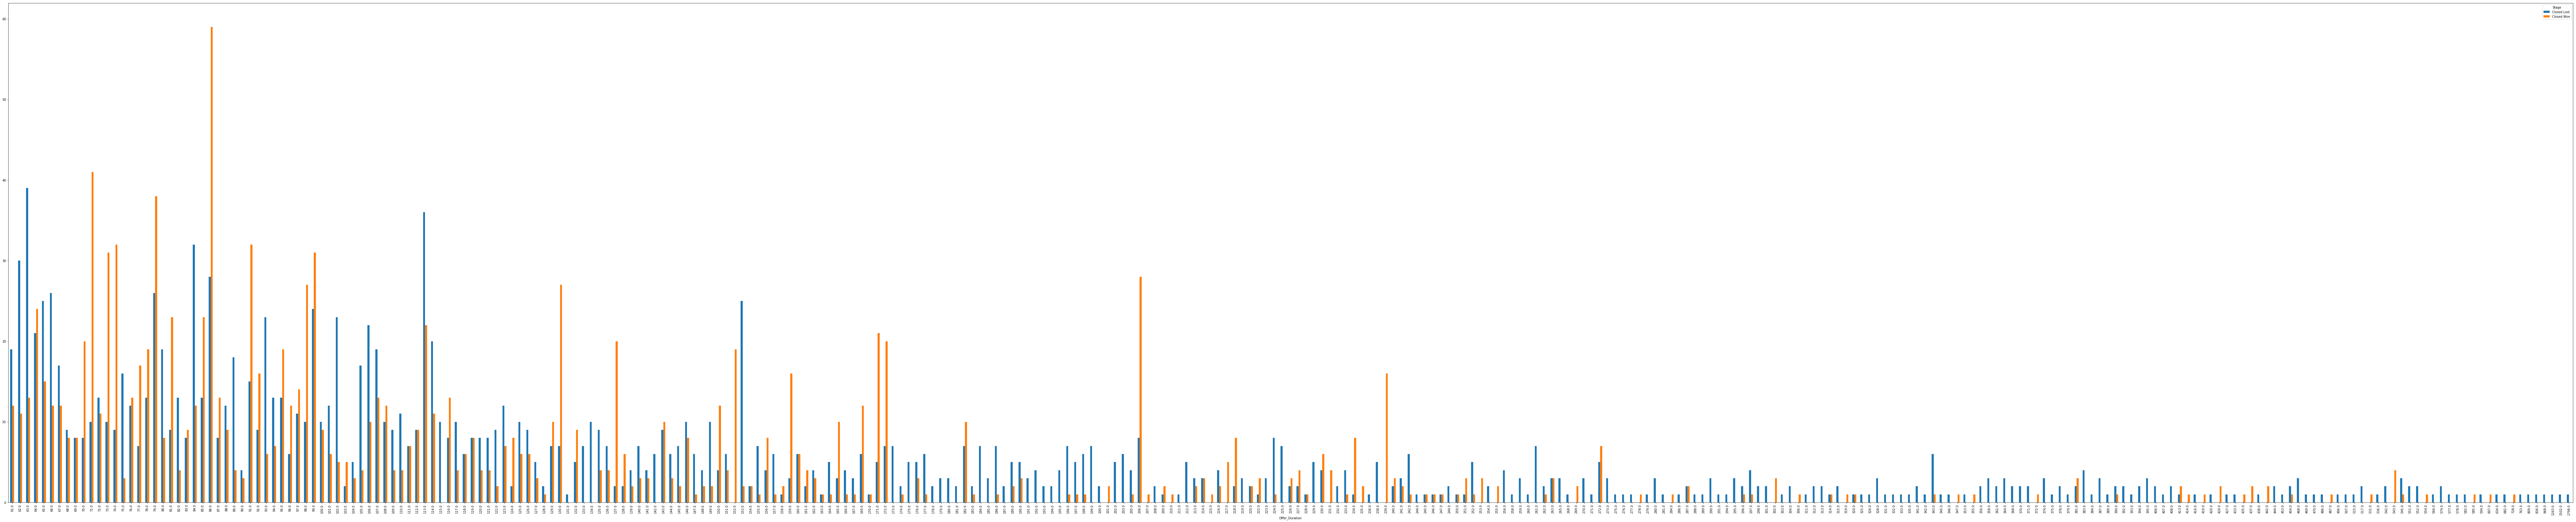

In [53]:
pd.crosstab(data[data.Offer_Duration > 60].Offer_Duration, data.Stage).plot(kind='bar', figsize=(150, 30))

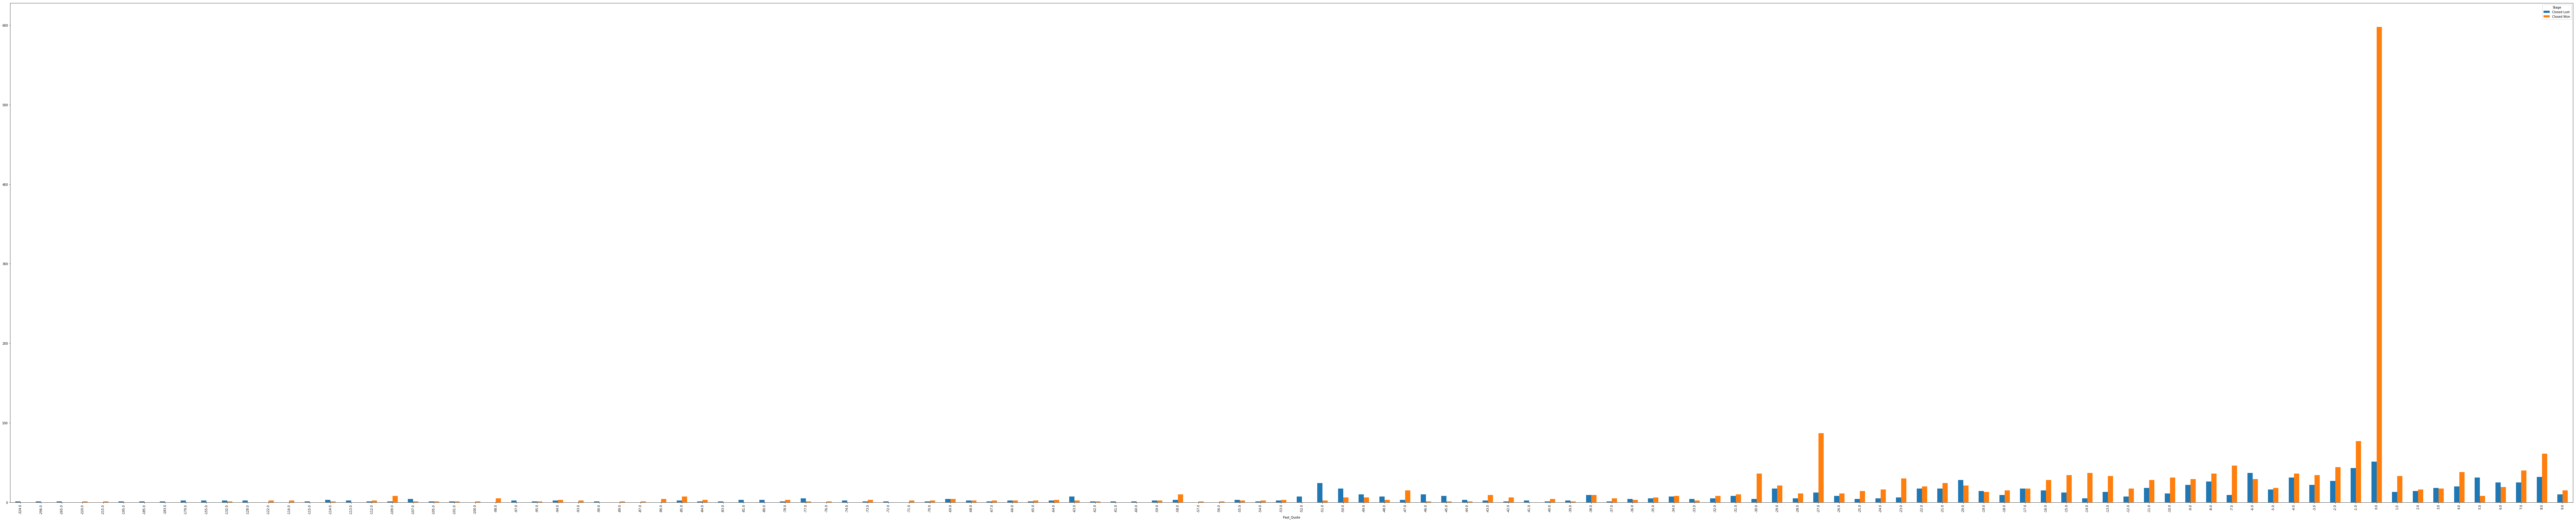

In [43]:
pd.crosstab(data[(data.Past_Quote < 10)].Past_Quote, data.Stage).plot(kind='bar', figsize=(150, 30))

In [328]:
df = preprocess(data)

In [329]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size=0.3, random_state=0)
categorical = [x for x in df.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage'] + ["TRF_Cat"]
#categorical = [x for x in cat_vars if x in df.columns]
train_data = lgb.Dataset(data=x_train.drop(target, axis=1), label=x_train.Stage, categorical_feature=categorical)
test_data =  lgb.Dataset(data=x_test.drop(target, axis=1), label=x_test.Stage)

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'max_depth': 7,
    'learning_rate': 0.015,
    'max_bin': 300,
    'verbose': 0
}

model = lgb.train(parameters,
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=5000,
                  early_stopping_rounds=500)

[1]	valid_0's binary_logloss: 0.673699
Training until validation scores don't improve for 500 rounds
[2]	valid_0's binary_logloss: 0.661112
[3]	valid_0's binary_logloss: 0.653933
[4]	valid_0's binary_logloss: 0.647062
[5]	valid_0's binary_logloss: 0.64052
[6]	valid_0's binary_logloss: 0.63408
[7]	valid_0's binary_logloss: 0.622782
[8]	valid_0's binary_logloss: 0.616741
[9]	valid_0's binary_logloss: 0.610172
[10]	valid_0's binary_logloss: 0.604268
[11]	valid_0's binary_logloss: 0.598629
[12]	valid_0's binary_logloss: 0.593162
[13]	valid_0's binary_logloss: 0.587614
[14]	valid_0's binary_logloss: 0.577523
[15]	valid_0's binary_logloss: 0.567782
[16]	valid_0's binary_logloss: 0.562498
[17]	valid_0's binary_logloss: 0.557324
[18]	valid_0's binary_logloss: 0.547977
[19]	valid_0's binary_logloss: 0.53895
[20]	valid_0's binary_logloss: 0.530092
[21]	valid_0's binary_logloss: 0.525843
[22]	valid_0's binary_logloss: 0.521781
[23]	valid_0's binary_logloss: 0.51751
[24]	valid_0's binary_logloss: 

[248]	valid_0's binary_logloss: 0.114402
[249]	valid_0's binary_logloss: 0.113766
[250]	valid_0's binary_logloss: 0.113534
[251]	valid_0's binary_logloss: 0.113324
[252]	valid_0's binary_logloss: 0.112814
[253]	valid_0's binary_logloss: 0.112633
[254]	valid_0's binary_logloss: 0.112105
[255]	valid_0's binary_logloss: 0.111897
[256]	valid_0's binary_logloss: 0.111729
[257]	valid_0's binary_logloss: 0.111593
[258]	valid_0's binary_logloss: 0.111043
[259]	valid_0's binary_logloss: 0.110547
[260]	valid_0's binary_logloss: 0.109999
[261]	valid_0's binary_logloss: 0.1098
[262]	valid_0's binary_logloss: 0.109297
[263]	valid_0's binary_logloss: 0.109129
[264]	valid_0's binary_logloss: 0.108631
[265]	valid_0's binary_logloss: 0.108488
[266]	valid_0's binary_logloss: 0.108045
[267]	valid_0's binary_logloss: 0.107598
[268]	valid_0's binary_logloss: 0.107431
[269]	valid_0's binary_logloss: 0.10731
[270]	valid_0's binary_logloss: 0.107152
[271]	valid_0's binary_logloss: 0.106972
[272]	valid_0's bin

[494]	valid_0's binary_logloss: 0.0717002
[495]	valid_0's binary_logloss: 0.0715785
[496]	valid_0's binary_logloss: 0.0715376
[497]	valid_0's binary_logloss: 0.0714547
[498]	valid_0's binary_logloss: 0.0714442
[499]	valid_0's binary_logloss: 0.0713724
[500]	valid_0's binary_logloss: 0.0713123
[501]	valid_0's binary_logloss: 0.0712691
[502]	valid_0's binary_logloss: 0.0712062
[503]	valid_0's binary_logloss: 0.0711135
[504]	valid_0's binary_logloss: 0.0710301
[505]	valid_0's binary_logloss: 0.0709864
[506]	valid_0's binary_logloss: 0.0709469
[507]	valid_0's binary_logloss: 0.0708882
[508]	valid_0's binary_logloss: 0.0708156
[509]	valid_0's binary_logloss: 0.0707146
[510]	valid_0's binary_logloss: 0.0706542
[511]	valid_0's binary_logloss: 0.0705915
[512]	valid_0's binary_logloss: 0.070541
[513]	valid_0's binary_logloss: 0.070458
[514]	valid_0's binary_logloss: 0.0703613
[515]	valid_0's binary_logloss: 0.0703139
[516]	valid_0's binary_logloss: 0.0702317
[517]	valid_0's binary_logloss: 0.07

[787]	valid_0's binary_logloss: 0.0606282
[788]	valid_0's binary_logloss: 0.0606523
[789]	valid_0's binary_logloss: 0.0606454
[790]	valid_0's binary_logloss: 0.0606351
[791]	valid_0's binary_logloss: 0.0606355
[792]	valid_0's binary_logloss: 0.0606329
[793]	valid_0's binary_logloss: 0.0606084
[794]	valid_0's binary_logloss: 0.060594
[795]	valid_0's binary_logloss: 0.0605702
[796]	valid_0's binary_logloss: 0.0605616
[797]	valid_0's binary_logloss: 0.0605488
[798]	valid_0's binary_logloss: 0.0605149
[799]	valid_0's binary_logloss: 0.0605255
[800]	valid_0's binary_logloss: 0.060531
[801]	valid_0's binary_logloss: 0.0605217
[802]	valid_0's binary_logloss: 0.0604905
[803]	valid_0's binary_logloss: 0.0605067
[804]	valid_0's binary_logloss: 0.0605314
[805]	valid_0's binary_logloss: 0.0605441
[806]	valid_0's binary_logloss: 0.0605338
[807]	valid_0's binary_logloss: 0.0605318
[808]	valid_0's binary_logloss: 0.0605534
[809]	valid_0's binary_logloss: 0.0605371
[810]	valid_0's binary_logloss: 0.06

[1033]	valid_0's binary_logloss: 0.0587937
[1034]	valid_0's binary_logloss: 0.0587968
[1035]	valid_0's binary_logloss: 0.058803
[1036]	valid_0's binary_logloss: 0.0587703
[1037]	valid_0's binary_logloss: 0.0587564
[1038]	valid_0's binary_logloss: 0.058759
[1039]	valid_0's binary_logloss: 0.0587537
[1040]	valid_0's binary_logloss: 0.0587102
[1041]	valid_0's binary_logloss: 0.0587174
[1042]	valid_0's binary_logloss: 0.0586988
[1043]	valid_0's binary_logloss: 0.0586819
[1044]	valid_0's binary_logloss: 0.0586775
[1045]	valid_0's binary_logloss: 0.0586525
[1046]	valid_0's binary_logloss: 0.0586565
[1047]	valid_0's binary_logloss: 0.0586618
[1048]	valid_0's binary_logloss: 0.0586512
[1049]	valid_0's binary_logloss: 0.0586184
[1050]	valid_0's binary_logloss: 0.0586041
[1051]	valid_0's binary_logloss: 0.0585986
[1052]	valid_0's binary_logloss: 0.0585892
[1053]	valid_0's binary_logloss: 0.058609
[1054]	valid_0's binary_logloss: 0.0586177
[1055]	valid_0's binary_logloss: 0.0586154
[1056]	valid_0

[1267]	valid_0's binary_logloss: 0.0586627
[1268]	valid_0's binary_logloss: 0.058698
[1269]	valid_0's binary_logloss: 0.0587068
[1270]	valid_0's binary_logloss: 0.058736
[1271]	valid_0's binary_logloss: 0.0587618
[1272]	valid_0's binary_logloss: 0.0587603
[1273]	valid_0's binary_logloss: 0.0587659
[1274]	valid_0's binary_logloss: 0.0588276
[1275]	valid_0's binary_logloss: 0.0588285
[1276]	valid_0's binary_logloss: 0.0588436
[1277]	valid_0's binary_logloss: 0.0589111
[1278]	valid_0's binary_logloss: 0.0589386
[1279]	valid_0's binary_logloss: 0.0589616
[1280]	valid_0's binary_logloss: 0.0590268
[1281]	valid_0's binary_logloss: 0.0590017
[1282]	valid_0's binary_logloss: 0.0589867
[1283]	valid_0's binary_logloss: 0.0589878
[1284]	valid_0's binary_logloss: 0.0590138
[1285]	valid_0's binary_logloss: 0.0590041
[1286]	valid_0's binary_logloss: 0.0589629
[1287]	valid_0's binary_logloss: 0.0589665
[1288]	valid_0's binary_logloss: 0.0589606
[1289]	valid_0's binary_logloss: 0.058959
[1290]	valid_0

[1516]	valid_0's binary_logloss: 0.0602369
[1517]	valid_0's binary_logloss: 0.0602564
[1518]	valid_0's binary_logloss: 0.0602684
[1519]	valid_0's binary_logloss: 0.0603093
[1520]	valid_0's binary_logloss: 0.0603416
[1521]	valid_0's binary_logloss: 0.0603277
[1522]	valid_0's binary_logloss: 0.0603139
[1523]	valid_0's binary_logloss: 0.0602612
[1524]	valid_0's binary_logloss: 0.0602594
[1525]	valid_0's binary_logloss: 0.0602182
[1526]	valid_0's binary_logloss: 0.0602116
[1527]	valid_0's binary_logloss: 0.0601998
[1528]	valid_0's binary_logloss: 0.060178
[1529]	valid_0's binary_logloss: 0.0601382
[1530]	valid_0's binary_logloss: 0.0601375
[1531]	valid_0's binary_logloss: 0.0601118
[1532]	valid_0's binary_logloss: 0.0601066
[1533]	valid_0's binary_logloss: 0.0601024
[1534]	valid_0's binary_logloss: 0.0601051
[1535]	valid_0's binary_logloss: 0.060086
[1536]	valid_0's binary_logloss: 0.0600646
[1537]	valid_0's binary_logloss: 0.060051
[1538]	valid_0's binary_logloss: 0.0600752
[1539]	valid_0

In [330]:
res = model.predict(x_test.drop(target, axis=1))

In [331]:
for x in res[:10]:
    print("{:f}".format(x))

0.000192
0.005806
0.999328
0.999497
0.145090
0.958281
0.003036
0.000027
0.996120
0.000444


In [332]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [333]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [340]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [341]:
log_loss(answer["Stage"], answer["Prediction"])

0.06689944247840729

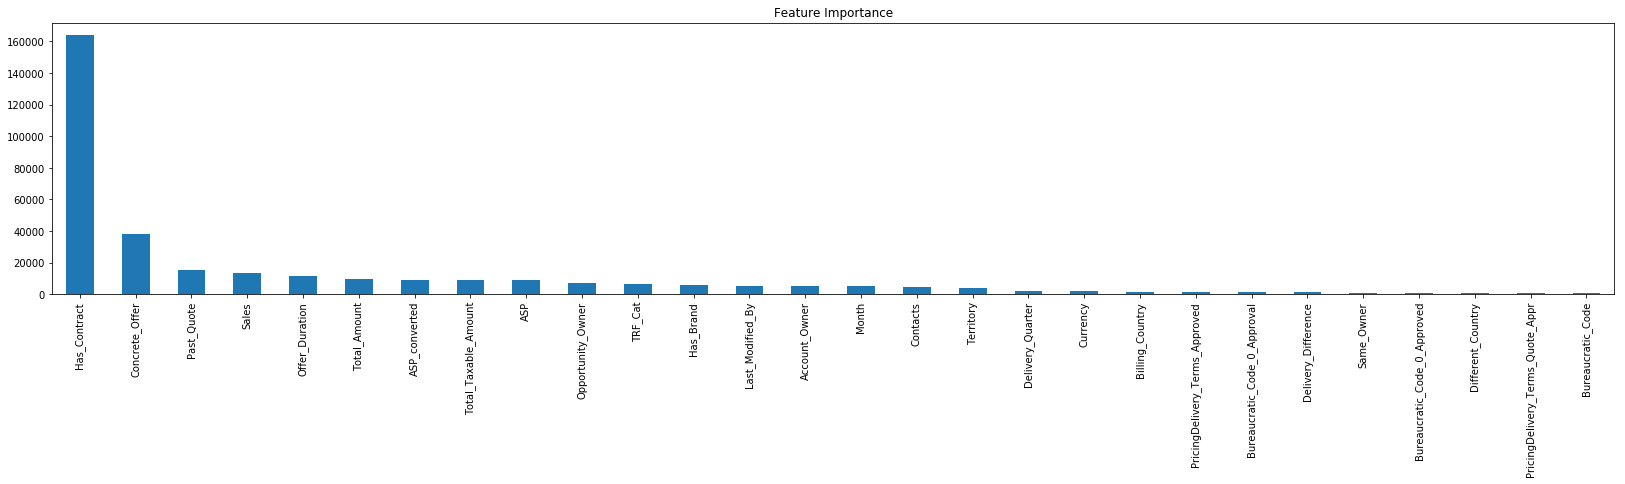

In [336]:
predictors = [x for x in x_train.drop(target, axis=1).columns]
feat_imp = pd.Series(model.feature_importance("gain"), predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind='bar', title='Feature Importance')

In [59]:
print feat_imp

Has_Contract                        163097.413805
Concrete_Offer                       37401.100655
Past_Quote                           15202.747043
Sales                                12984.901460
Offer_Duration                       10877.801990
ASP_converted                         9249.976731
Total_Taxable_Amount                  9039.670796
Total_Amount                          8817.385124
ASP                                   8745.588778
Opportunity_Owner                     7170.956448
TRF_Cat                               6638.135887
Delivery_Difference                   6422.155923
Has_Brand                             5684.645709
Account_Owner                         5429.592963
Last_Modified_By                      5331.544920
Month                                 4745.909321
Contacts                              4136.982718
Territory                             3792.144408
Delivery_Quarter                      2248.249516
Currency                              2183.644338


In [342]:
vali = pd.read_csv("Validacion_ECI_2020.csv")

In [343]:
validation = preprocess(vali)

In [96]:
len(validation[validation.Contacts > 0])

2551

In [344]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred_vali = model.predict(validation.drop(leak, axis = 1))

In [345]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [346]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [347]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9869368091813757

In [349]:
answer.to_csv("fabri/lgbm.csv", index = False, header = False)

In [292]:
vali.ASP_Currency.value_counts()

USD    1547
EUR     836
JPY     168
Name: ASP_Currency, dtype: int64

In [103]:
pred_vali["Max_pred"] = pred_vali.groupby("Opportunity_ID", sort = False)["Prediction"].transform("max")
pred_vali["Min_pred"] = pred_vali.groupby("Opportunity_ID", sort = False)["Prediction"].transform("min")

#y busqué aquellas en las que difieren
pred_vali[pred_vali.Max_pred - pred_vali.Min_pred > 0.1]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Currency,Last_Modified_By,ASP,ASP_converted,Month,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote,Prediction,Max_pred,Min_pred
330,Japan,None,1,1,1,1,Bureaucratic_Code_4,None,Japan,10876,None,Person_Name_50,Person_Name_50,Account_Type_2,None,Person_Name_50,NaN,NaN,2,Q1,43000.00,94840.00,2,0.0,True,False,False,False,0.0,6,9.0,6.0,False,0.0,0.083495,0.263911,0.083495
331,Japan,None,1,1,1,1,Bureaucratic_Code_4,None,Japan,10876,None,Person_Name_50,Person_Name_50,Account_Type_2,None,Person_Name_50,48.000,0.43154,2,Q1,51840.00,94840.00,2,0.0,True,False,False,False,0.0,6,9.0,6.0,False,0.0,0.263911,0.263911,0.083495
341,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,Source_9,United States,10886,5725,Person_Name_64,Person_Name_64,Account_Type_2,None,Person_Name_64,NaN,NaN,7,Q3,0.48,5557.98,2,0.0,True,False,True,True,0.0,13,172.0,7.0,True,68.0,0.480130,0.815143,0.480130
342,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,Source_9,United States,10886,5725,Person_Name_64,Person_Name_64,Account_Type_2,None,Person_Name_64,0.380,0.38000,7,Q3,5557.50,5557.98,2,0.0,True,False,True,True,0.0,13,172.0,7.0,True,68.0,0.815143,0.815143,0.480130
691,Americas,NW America,1,1,1,1,Bureaucratic_Code_4,None,United States,11093,5830,Person_Name_64,Person_Name_64,Account_Type_2,None,Person_Name_64,0.425,0.42500,11,Q4,115706.25,446490.00,4,0.0,True,False,True,True,0.0,7,295.0,21.0,True,34.0,0.361894,0.480646,0.361894
692,Americas,NW America,1,1,1,1,Bureaucratic_Code_4,None,United States,11093,5830,Person_Name_64,Person_Name_64,Account_Type_2,None,Person_Name_64,0.405,0.40500,12,Q4,110261.25,446490.00,4,0.0,True,False,True,True,0.0,7,298.0,21.0,True,34.0,0.480646,0.480646,0.361894
693,Americas,NW America,1,1,1,1,Bureaucratic_Code_4,None,United States,11093,5830,Person_Name_64,Person_Name_64,Account_Type_2,None,Person_Name_64,0.405,0.40500,10,Q4,110261.25,446490.00,4,0.0,True,False,True,True,0.0,7,242.0,21.0,True,34.0,0.382482,0.480646,0.361894
694,Americas,NW America,1,1,1,1,Bureaucratic_Code_4,None,United States,11093,5830,Person_Name_64,Person_Name_64,Account_Type_2,None,Person_Name_64,0.405,0.40500,11,Q4,110261.25,446490.00,4,11.0,True,False,True,True,0.0,7,281.0,21.0,True,34.0,0.373497,0.480646,0.361894
963,Americas,NW America,1,1,1,1,Bureaucratic_Code_4,None,United States,11382,5847,Person_Name_64,Person_Name_64,Account_Type_2,None,Person_Name_64,NaN,NaN,10,Q4,450.00,21236.00,2,0.0,True,False,True,True,0.0,7,235.0,20.0,True,40.0,0.363712,0.613123,0.363712
964,Americas,NW America,1,1,1,1,Bureaucratic_Code_4,None,United States,11382,5847,Person_Name_64,Person_Name_64,Account_Type_2,None,Person_Name_64,0.405,0.40500,10,Q4,10773.00,21236.00,2,0.0,True,False,True,True,0.0,7,235.0,20.0,True,40.0,0.613123,0.613123,0.363712
